<a href="https://colab.research.google.com/github/ethmanemahmoudethmane/Movie_recommandation/blob/main/MovieLens_1M_Recommandation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 MovieLens 1M
Prétraitement **+** Modèle MF PyTorch **+** EDA (graphiques) avec split temporel par **quantiles**

In [ ]:
#@title ✅ Imports
import os, zipfile, time, json as _json
from pathlib import Path
import numpy as np
import pandas as pd
import re
from joblib import dump
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [ ]:
#@title 📁 Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')
print('✅ Drive monté')

Mounted at /content/drive
✅ Drive monté


In [ ]:
#@title 🛣️ Chemins & options
DRIVE_BASE = '/content/drive/MyDrive/movielens'  #@param {type:"string"}
BASE_DIR = Path(DRIVE_BASE)
BASE_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = BASE_DIR / 'ml-1m'
ZIP_PATH = BASE_DIR / 'ml-1m.zip'
print('BASE_DIR:', BASE_DIR)

BASE_DIR: /content/drive/MyDrive/movielens


In [ ]:
#@title 🗜️ Décompresser si ml-1m.zip est présent
if ZIP_PATH.exists() and not DATA_DIR.exists():
    print('ml-1m.zip détecté → décompression…')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(BASE_DIR)
    print('✅ Décompression terminée')
else:
    print('Aucune décompression nécessaire')

Aucune décompression nécessaire


In [ ]:
#@title 🔎 Vérifier le dossier ml-1m
if DATA_DIR.exists():
    print('✅ Dossier trouvé:', DATA_DIR)
    print('Contenu:', sorted(os.listdir(DATA_DIR))[:6])
else:
    raise FileNotFoundError('❌ Dossier ml-1m introuvable. Placez ml-1m/ ou ml-1m.zip dans ' + str(BASE_DIR))

✅ Dossier trouvé: /content/drive/MyDrive/movielens/ml-1m
Contenu: ['README', 'movies.dat', 'ratings.dat', 'users.dat']


In [ ]:
#@title ⬇️ Chargement typé des 3 fichiers
ratings_cols = ['UserID','MovieID','Rating','Timestamp']
users_cols   = ['UserID','Gender','Age','Occupation','Zip-code']
movies_cols  = ['MovieID','Title','Genres']

ratings_df = pd.read_csv(DATA_DIR / 'ratings.dat', sep='::', engine='python', names=ratings_cols,
    dtype={'UserID':'int32','MovieID':'int32','Rating':'int8','Timestamp':'int64'})
users_df   = pd.read_csv(DATA_DIR / 'users.dat', sep='::', engine='python', names=users_cols,
    dtype={'UserID':'int32','Gender':'category','Age':'int16','Occupation':'int16','Zip-code':'string'})
movies_df  = pd.read_csv(DATA_DIR / 'movies.dat', sep='::', engine='python', names=movies_cols,
    dtype={'MovieID':'int32','Title':'string','Genres':'string'}, encoding='latin-1')

assert ratings_df['Rating'].between(1,5).all()
print('shapes:', ratings_df.shape, users_df.shape, movies_df.shape)

shapes: (1000209, 4) (6040, 5) (3883, 3)


In [ ]:
#@title 📆 Année + Titre nettoyé
movies_df['Year'] = movies_df['Title'].str.extract(r'\((\d{4})\)\s*$', expand=False).astype('Int64')
movies_df.loc[~movies_df['Year'].between(1900, 2025), 'Year'] = pd.NA
movies_df['Clean_Title'] = movies_df['Title'].str.replace(r'\s*\((\d{4})\)\s*$', '', regex=True).str.strip()
movies_df[['Title','Clean_Title','Year']].head(3)

,Title,Clean_Title,Year
0,Toy Story (1995),Toy Story,1995
1,Jumanji (1995),Jumanji,1995
2,Grumpier Old Men (1995),Grumpier Old Men,1995


In [ ]:
#@title 🧮 Doublons user–movie → garder la dernière note
ratings_df = ratings_df.sort_values('Timestamp').drop_duplicates(['UserID','MovieID'], keep='last')
ratings_df.head(3)

,UserID,MovieID,Rating,Timestamp
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954


In [ ]:
#@title 🔗 Fusion des tables
df = pd.merge(ratings_df, users_df, on='UserID', how='left')
df = pd.merge(df, movies_df, on='MovieID', how='left')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Year_of_Rating'] = df['Timestamp'].dt.year
df.head(3)

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,Year,Clean_Title,Year_of_Rating
0,6040,858,4,2000-04-25 23:05:32,M,25,6,11106,"Godfather, The (1972)",Action|Crime|Drama,1972,"Godfather, The",2000
1,6040,593,5,2000-04-25 23:05:54,M,25,6,11106,"Silence of the Lambs, The (1991)",Drama|Thriller,1991,"Silence of the Lambs, The",2000
2,6040,2384,4,2000-04-25 23:05:54,M,25,6,11106,Babe: Pig in the City (1998),Children's|Comedy,1998,Babe: Pig in the City,2000


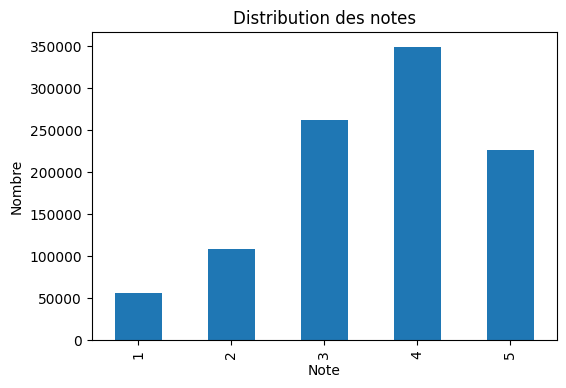

In [ ]:
#@title 📊 Viz: Distribution des notes (counts)
counts = df['Rating'].value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Nombre')
plt.show()

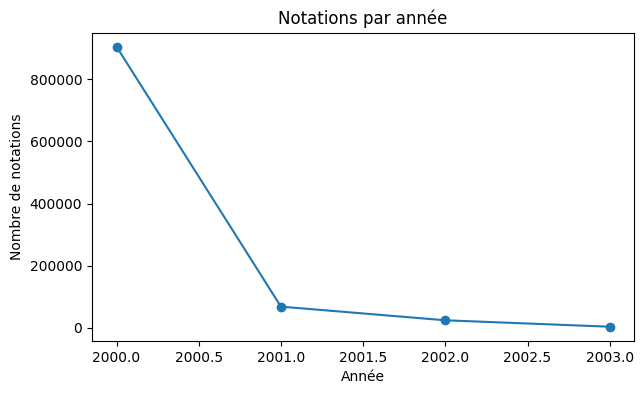

In [ ]:
#@title 📈 Viz: Nombre de notations par année
per_year = df.groupby('Year_of_Rating')['Rating'].count().sort_index()
plt.figure(figsize=(7,4))
per_year.plot(kind='line', marker='o')
plt.title('Notations par année')
plt.xlabel('Année')
plt.ylabel('Nombre de notations')
plt.show()

In [ ]:
#@title 🧩 Genres (One-Hot) + Âge du film à la notation
genres_ohe = df['Genres'].str.get_dummies('|').astype('UInt8').add_prefix('Genre_')
df = pd.concat([df, genres_ohe], axis=1)
df['Movie_Age_at_Rating'] = (df['Timestamp'].dt.year - df['Year']).where(df['Year'].notna())
df.loc[df['Movie_Age_at_Rating'] < 0, 'Movie_Age_at_Rating'] = pd.NA
df.filter(like='Genre_').head(1)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


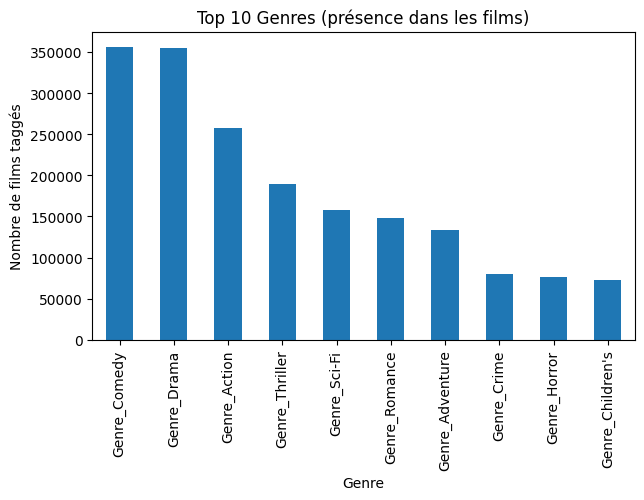

In [ ]:
#@title 🧭 Viz: Top 10 genres par présence
genre_totals = genres_ohe.sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(7,4))
genre_totals.plot(kind='bar')
plt.title('Top 10 Genres (présence dans les films)')
plt.xlabel('Genre')
plt.ylabel('Nombre de films taggés')
plt.show()

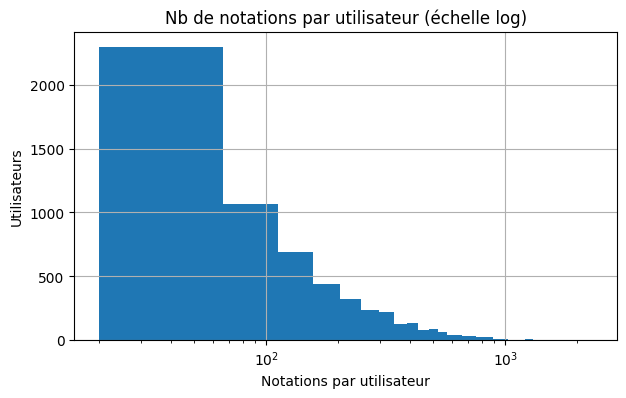

In [ ]:
#@title 👤 Viz: Distribution du nombre de notations par utilisateur (log-scale)
user_counts = df.groupby('UserID')['Rating'].count()
plt.figure(figsize=(7,4))
user_counts.hist(bins=50)
plt.xscale('log')
plt.title('Nb de notations par utilisateur (échelle log)')
plt.xlabel('Notations par utilisateur')
plt.ylabel('Utilisateurs')
plt.show()

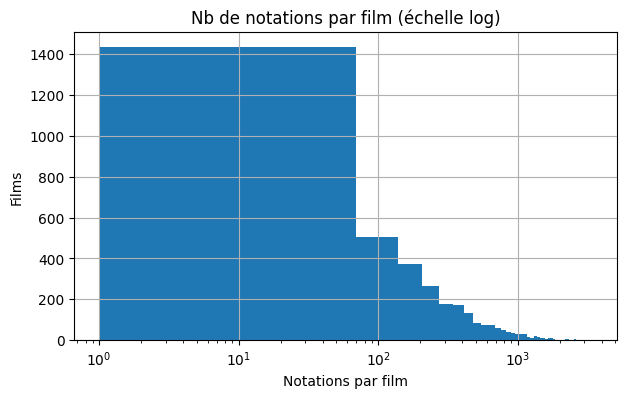

In [ ]:
#@title 🎞️ Viz: Distribution du nombre de notations par film (log-scale)
movie_counts = df.groupby('MovieID')['Rating'].count()
plt.figure(figsize=(7,4))
movie_counts.hist(bins=50)
plt.xscale('log')
plt.title('Nb de notations par film (échelle log)')
plt.xlabel('Notations par film')
plt.ylabel('Films')
plt.show()

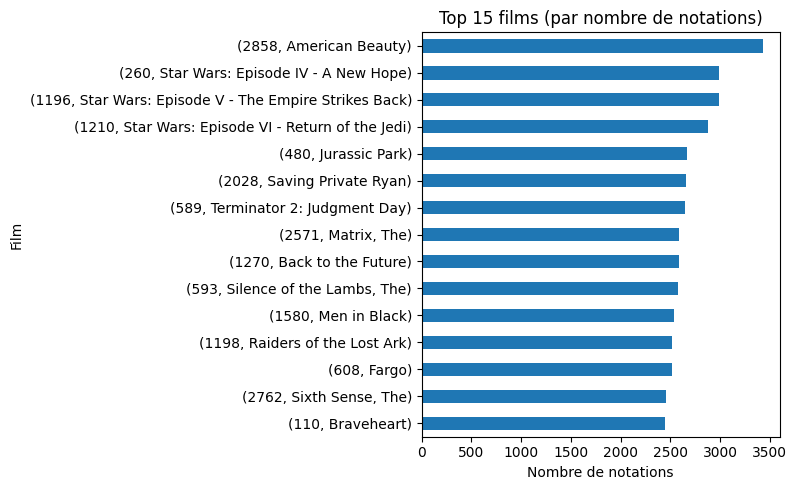

In [ ]:
#@title 🏆 Viz: Top 15 films par nombre de notations
top_movies = df.groupby(['MovieID','Clean_Title'])['Rating'].count().sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
top_movies.sort_values().plot(kind='barh')
plt.title('Top 15 films (par nombre de notations)')
plt.xlabel('Nombre de notations')
plt.ylabel('Film')
plt.tight_layout()
plt.show()

In [ ]:
#@title ✂️ Split temporel automatique (60/20/20 par quantiles)
ts_sorted = df['Timestamp'].sort_values().values
q60 = pd.to_datetime(np.quantile(ts_sorted, 0.60))
q80 = pd.to_datetime(np.quantile(ts_sorted, 0.80))
print('Cutoffs:', q60, q80)
train = df[df['Timestamp'] < q60].copy()
val   = df[(df['Timestamp'] >= q60) & (df['Timestamp'] < q80)].copy()
test  = df[df['Timestamp'] >= q80].copy()
print('train/val/test:', len(train), len(val), len(test))

Cutoffs: 2000-11-20 02:39:25 2000-12-02 14:52:18
train/val/test: 600124 200040 200045


In [ ]:
#@title 📊 Agrégats (TRAIN only) + merge vers val/test
global_mean = train['Rating'].mean()
user_stats  = train.groupby('UserID')['Rating'].agg(User_Avg_Rating='mean', User_Ratings_Count='count')
movie_stats = train.groupby('MovieID')['Rating'].agg(Movie_Avg_Rating='mean', Movie_Ratings_Count='count')

def attach_stats(part):
    part = part.merge(user_stats, on='UserID', how='left').merge(movie_stats, on='MovieID', how='left')
    part['User_Avg_Rating']  = part['User_Avg_Rating'].fillna(global_mean)
    part['Movie_Avg_Rating'] = part['Movie_Avg_Rating'].fillna(global_mean)
    part['User_Ratings_Count']  = part['User_Ratings_Count'].fillna(0).astype('int32')
    part['Movie_Ratings_Count'] = part['Movie_Ratings_Count'].fillna(0).astype('int32')
    return part

train = attach_stats(train); val = attach_stats(val); test = attach_stats(test)
print('Done: agrégats attachés (sans fuite).')

Done: agrégats attachés (sans fuite).


In [ ]:
#@title 💾 Exports (Parquet + CSV) & Rapport JSON
train.to_parquet(BASE_DIR / 'train.parquet', index=False)
val.to_parquet(BASE_DIR / 'val.parquet', index=False)
test.to_parquet(BASE_DIR / 'test.parquet', index=False)
train.to_csv(BASE_DIR / 'train.csv', index=False)
val.to_csv(BASE_DIR / 'val.csv', index=False)
test.to_csv(BASE_DIR / 'test.csv', index=False)
report = {
  'pandas': pd.__version__,
  'n_users': int(df['UserID'].nunique()),
  'n_movies': int(df['MovieID'].nunique()),
  'n_ratings': int(len(df)),
  'split': {'train': int(len(train)), 'val': int(len(val)), 'test': int(len(test))},
  'timestamp': time.time()
}
with open(BASE_DIR / 'preprocess_report.json','w') as f:
    _json.dump(report, f, indent=2)
print('✅ Exports enregistrés dans', BASE_DIR)

✅ Exports enregistrés dans /content/drive/MyDrive/movielens


In [ ]:
#@title 🔑 Encodage User/Movie depuis TRAIN
users_train = train['UserID'].unique()
movies_train = train['MovieID'].unique()
user2idx = {u:i for i,u in enumerate(users_train)}
movie2idx = {m:i for i,m in enumerate(movies_train)}
idx2movie = {i:m for m,i in movie2idx.items()}
print('n_users:', len(user2idx), '| n_movies:', len(movie2idx))

n_users: 4082 | n_movies: 3575


In [ ]:
#@title 🛡️ Map IDs & Sanitize dtypes (torch-ready)

def map_ids(df):
    df = df.copy()
    df['u_idx'] = df['UserID'].map(user2idx)
    df['m_idx'] = df['MovieID'].map(movie2idx)
    return df

def sanitize_for_torch(df):
    df = df.copy()
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce').astype('float32')
    df['u_idx']  = pd.to_numeric(df['u_idx'],  errors='coerce')
    df['m_idx']  = pd.to_numeric(df['m_idx'],  errors='coerce')
    df = df.dropna(subset=['Rating','u_idx','m_idx'])
    df['u_idx'] = df['u_idx'].astype('int64')
    df['m_idx'] = df['m_idx'].astype('int64')
    return df.reset_index(drop=True)

train_t = sanitize_for_torch(map_ids(train))
val_t   = sanitize_for_torch(map_ids(val))
print('Rows train/val:', len(train_t), len(val_t))

Rows train/val: 600124 12969


In [ ]:
#@title 🚚 DataLoaders
class RatingsDS(Dataset):
    def __init__(self, df):
        self.u = torch.tensor(df['u_idx'].values, dtype=torch.long)
        self.m = torch.tensor(df['m_idx'].values, dtype=torch.long)
        self.y = torch.tensor(df['Rating'].values, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.u[idx], self.m[idx], self.y[idx]

BATCH = 4096  #@param {type:"integer"}
BATCH = min(BATCH, max(1, len(train_t)))
train_dl = DataLoader(RatingsDS(train_t), batch_size=BATCH, shuffle=True,  num_workers=0)
val_dl   = DataLoader(RatingsDS(val_t),   batch_size=BATCH, shuffle=False, num_workers=0)
print('✔️ DL prêts | batch:', BATCH)

✔️ DL prêts | batch: 4096


In [ ]:
#@title 🧠 Modèle MF (embeddings + biais)
class MF(nn.Module):
    def __init__(self, n_users, n_movies, emb=64, dropout=0.2, min_rating=1.0, max_rating=5.0, init_global_bias=None):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb)
        self.movie_emb = nn.Embedding(n_movies, emb)
        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_bias = nn.Embedding(n_movies, 1)
        self.global_bias = nn.Parameter(torch.tensor([init_global_bias if init_global_bias is not None else 0.0]))
        self.do = nn.Dropout(dropout)
        self.min_rating = min_rating
        self.max_rating = max_rating
        nn.init.normal_(self.user_emb.weight, 0, 0.1)
        nn.init.normal_(self.movie_emb.weight, 0, 0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
    def forward(self, u, m):
        u_vec = self.do(self.user_emb(u))
        m_vec = self.do(self.movie_emb(m))
        dot = (u_vec*m_vec).sum(dim=1)
        b = self.user_bias(u).squeeze(1) + self.movie_bias(m).squeeze(1) + self.global_bias
        out = dot + b
        return torch.clamp(out, self.min_rating, self.max_rating)

In [ ]:
#@title 🚂 Entraînement + validation (trajectoires RMSE/MAE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MF(len(user2idx), len(movie2idx), emb=64, dropout=0.2, init_global_bias=float(train_t['Rating'].mean())).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_fn = nn.MSELoss()
EPOCHS = 10  #@param {type:"integer"}

hist = {'train_loss': [], 'val_rmse': [], 'val_mae': []}
for epoch in range(1, EPOCHS+1):
    model.train(); losses=[]
    for (u,m,y) in train_dl:
        u,m,y = u.to(device), m.to(device), y.to(device)
        opt.zero_grad(); p = model(u,m)
        loss = loss_fn(p, y)
        loss.backward(); opt.step(); losses.append(loss.item())
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for (u,m,y) in val_dl:
            u,m,y = u.to(device), m.to(device), y.to(device)
            p = model(u,m)
            preds.append(p.cpu()); trues.append(y.cpu())
    preds = torch.cat(preds).numpy(); trues = torch.cat(trues).numpy()
    rmse = sqrt(mean_squared_error(trues, preds)); mae = mean_absolute_error(trues, preds)
    hist['train_loss'].append(float(np.mean(losses)))
    hist['val_rmse'].append(float(rmse))
    hist['val_mae'].append(float(mae))
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={hist['train_loss'][-1]:.4f} | val_RMSE={rmse:.4f} | val_MAE={mae:.4f}")

Epoch 1/10 | train_loss=1.1933 | val_RMSE=1.1350 | val_MAE=0.9298
Epoch 2/10 | train_loss=1.0858 | val_RMSE=1.1038 | val_MAE=0.8972
Epoch 3/10 | train_loss=1.0026 | val_RMSE=1.0786 | val_MAE=0.8688
Epoch 4/10 | train_loss=0.9337 | val_RMSE=1.0562 | val_MAE=0.8457
Epoch 5/10 | train_loss=0.8732 | val_RMSE=1.0369 | val_MAE=0.8273
Epoch 6/10 | train_loss=0.8177 | val_RMSE=1.0207 | val_MAE=0.8119
Epoch 7/10 | train_loss=0.7694 | val_RMSE=1.0059 | val_MAE=0.7987
Epoch 8/10 | train_loss=0.7286 | val_RMSE=0.9930 | val_MAE=0.7878
Epoch 9/10 | train_loss=0.6953 | val_RMSE=0.9834 | val_MAE=0.7796
Epoch 10/10 | train_loss=0.6660 | val_RMSE=0.9751 | val_MAE=0.7726


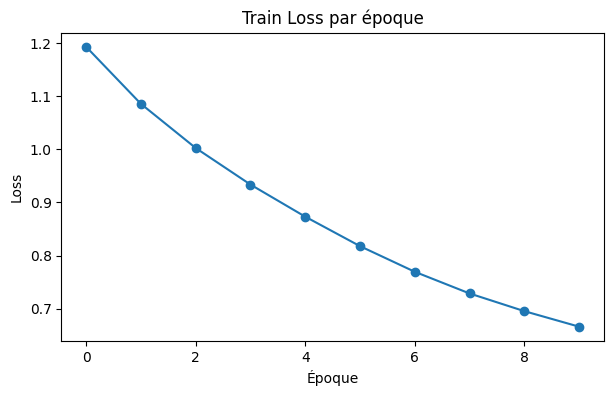

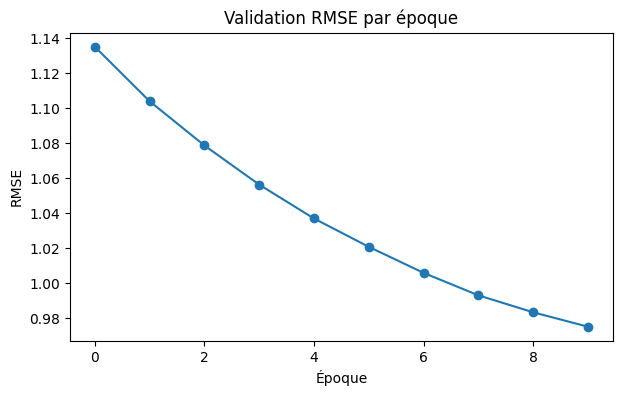

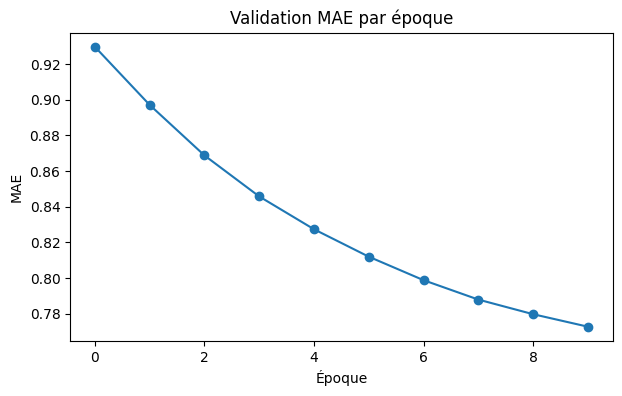

In [ ]:
#@title 📉 Viz: Courbes d'entraînement (Loss, RMSE, MAE)
plt.figure(figsize=(7,4))
plt.plot(hist['train_loss'], marker='o')
plt.title('Train Loss par époque')
plt.xlabel('Époque'); plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist['val_rmse'], marker='o')
plt.title('Validation RMSE par époque')
plt.xlabel('Époque'); plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist['val_mae'], marker='o')
plt.title('Validation MAE par époque')
plt.xlabel('Époque'); plt.ylabel('MAE')
plt.show()

In [ ]:
#@title 🎯 Recommander des films (exclut les films déjà vus)

def recommend_movies(raw_user_id, top_n=10):
    if raw_user_id not in user2idx:
        return ["UserID inconnu dans le train (cold-start)"]
    uid = user2idx[raw_user_id]
    device = next(model.parameters()).device
    all_m = torch.arange(len(movie2idx), dtype=torch.long, device=device)
    u_tensor = torch.full_like(all_m, fill_value=uid)
    with torch.no_grad():
        scores = model(u_tensor, all_m).cpu()
    seen = set(train_t.loc[train_t['UserID']==raw_user_id,'m_idx'].values)
    cand_idx = [i for i in range(len(movie2idx)) if i not in seen]
    if len(cand_idx) == 0:
        return ["Aucune recommandation (tous les films vus en train)"]
    cand_scores = scores[cand_idx]
    top = np.argsort(-cand_scores.numpy())[:top_n]
    top_movie_indices = [cand_idx[i] for i in top]
    return [idx2movie[i] for i in top_movie_indices]

In [ ]:
#@title 🎯 Recommandations lisibles
import pandas as pd
import numpy as np

# index rapide -> métadonnées film (si déjà fait plus haut, cette ligne est idempotente)
_movie_meta = movies_df.set_index('MovieID')[['Clean_Title','Year','Genres']]

def recommend_movies_pretty(raw_user_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Renvoie un DataFrame trié avec:
    rank, MovieID, Title, Year, Genres, PredScore
    - exclut les films déjà notés par l'utilisateur dans le train
    - utilise le modèle MF entraîné
    """
    if raw_user_id not in user2idx:
        return pd.DataFrame({'info': [f'UserID {raw_user_id} inconnu (cold-start)']})

    uid = user2idx[raw_user_id]
    device = next(model.parameters()).device

    # scores prédits pour TOUS les films connus du train
    all_m = torch.arange(len(movie2idx), dtype=torch.long, device=device)
    u_tensor = torch.full_like(all_m, fill_value=uid)

    with torch.no_grad():
        scores = model(u_tensor, all_m).cpu().numpy()

    # retirer les films déjà vus (dans le train)
    seen = set(train_t.loc[train_t['UserID'] == raw_user_id, 'm_idx'].tolist())
    cand_idx = [i for i in range(len(movie2idx)) if i not in seen]
    if len(cand_idx) == 0:
        return pd.DataFrame({'info': ['Aucune recommandation (tous les films sont déjà vus dans le train)']})

    cand_scores = scores[cand_idx]
    order_top = np.argsort(-cand_scores)[:top_n]

    # indices d'embedding -> MovieID "brut"
    top_midx = [cand_idx[i] for i in order_top]
    top_movie_ids = [int(idx2movie[i]) for i in top_midx]  # int() pour éviter np.int32
    top_scores = [float(cand_scores[i]) for i in order_top]

    # Récupérer les métadonnées; _movie_meta a MovieID en index -> on reindex puis reset_index proprement
    meta = _movie_meta.reindex(top_movie_ids).rename(columns={'Clean_Title': 'Title'}).reset_index()
    # S'assurer que la colonne issue de l'index s'appelle bien 'MovieID'
    if 'index' in meta.columns and 'MovieID' not in meta.columns:
        meta = meta.rename(columns={'index': 'MovieID'})

    # Ajouter les scores et ordonner selon le classement top
    meta['PredScore'] = np.round(top_scores, 3)

    # Réordonner exactement comme le top (évite les surprises de tri)
    order = pd.Index(top_movie_ids)
    # merge avec un DataFrame d'ordre pour un tri stable
    order_df = pd.DataFrame({'MovieID': top_movie_ids, '_rank_order': range(len(top_movie_ids))})
    meta = meta.merge(order_df, on='MovieID', how='left').sort_values('_rank_order').drop(columns=['_rank_order']).reset_index(drop=True)

    # Ajouter la colonne de rang
    meta.insert(0, 'rank', np.arange(1, len(meta) + 1))

    # Colonnes finales
    kept_cols = [c for c in ['rank', 'MovieID', 'Title', 'Year', 'Genres', 'PredScore'] if c in meta.columns]
    return meta[kept_cols]


In [ ]:
#@title 🧪 Exemple de sortie
some_user = int(train_t['UserID'].iloc[0]) if len(train_t) else list(user2idx.keys())[0]
reco_df = recommend_movies_pretty(some_user, top_n=10)
reco_df


,rank,MovieID,Title,Year,Genres,PredScore
0,1,1178,Paths of Glory,1957,Drama|War,4.763
1,2,1212,"Third Man, The",1949,Mystery|Thriller,4.610
2,3,1221,"Godfather: Part II, The",1974,Action|Crime|Drama,4.603
3,4,1267,"Manchurian Candidate, The",1962,Film-Noir|Thriller,4.600
4,5,1233,"Boat, The (Das Boot)",1981,Action|Drama|War,4.575
5,6,1204,Lawrence of Arabia,1962,Adventure|War,4.568
6,7,1207,To Kill a Mockingbird,1962,Drama,4.501
7,8,3030,Yojimbo,1961,Comedy|Drama|Western,4.460
8,9,3435,Double Indemnity,1944,Crime|Film-Noir,4.448
9,10,3037,Little Big Man,1970,Comedy|Drama|Western,4.384


In [ ]:
#@title 💾 Sauvegarder le modèle & mappings
torch.save(model.state_dict(), BASE_DIR / 'mf_model.pt')
with open(BASE_DIR / 'id_mappings.json', 'w') as f:
    _json.dump({'user2idx': {str(k):int(v) for k,v in user2idx.items()},
               'movie2idx': {str(k):int(v) for k,v in movie2idx.items()}}, f, indent=2)
print('✅ Artefacts sauvegardés dans', BASE_DIR)

✅ Artefacts sauvegardés dans /content/drive/MyDrive/movielens
